In [1]:
import numpy as np
import os
import glob
import pandas as pd
import itertools
from functools import reduce
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy import stats
from heatmap import heatmap

In [71]:
#uark Data
uark_path = r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Data'
uark_files = glob.glob(os.path.join(uark_path,'*.csv'))

In [72]:
# Data preparation for solarize Home design

#ac_path = r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Action'
ac_path = uark_path
os.chdir(ac_path)
all_file = os.listdir(ac_path)

all_action = []
for i in range(len(all_file)):
    p = list(pd.read_csv(all_file[i])['0'])
    all_action.append(p)
Merge_action = list(itertools.chain(*all_action))
Unique_action = set(Merge_action)
process = list(Unique_action)

In [73]:
process
state_process = [sub.replace('Add','Formulation') for sub in process]
state_process

['Show', 'Analysis', 'Edit', 'Formulation', 'Cost', 'Remove']

In [14]:
def first_order(file):
    Freq_count_1=pd.DataFrame(0,columns=process,index=process)
    Trans_prob_1=pd.DataFrame(0,columns=process,index=process)
    df=pd.read_csv(file,index_col=False,header=None)
    for i in range(len(process)):
        for j in range(len(process)):
            for k in range(len(df)-1):
                if((process[i]+ process[j])==(df[0][k]+df[0][k+1])):
                    Freq_count_1.iloc[i,j] +=1
    for i in range(len(Trans_prob_1)):
        Trans_prob_1.iloc[i,:]= Freq_count_1.iloc[i,:]/Freq_count_1.iloc[i,:].sum()
    Trans_prob_1=Trans_prob_1.fillna(0)
    return Trans_prob_1

In [29]:
excluded_designer = ['A02','D08','G10','A03','G03','B13']
testing_file = [i +'.csv' for i in excluded_designer]
train_file = [x for x in all_file if x not in testing_file]

In [15]:
def reward_gen(file_list):
    all_trans = []
    for i in range(len(file_list)):
        mc = first_order(file_list[i])
        all_trans.append(mc)
    reward = reduce(lambda x, y: x.add(y, fill_value=0), all_trans)
    return reward

In [17]:
#location_to_states = {process[x]:x for x in range(len(process))}
def state_location(unique_actions):
    dic = {j:i for i,j in enumerate(unique_actions)}
    return dic
location_to_states = state_location(state_process)
actions = [0,1,2,3,4,5]

state_to_location = dict((state,location) for location, state in location_to_states.items())
location_to_states

{'Show': 0, 'Analysis': 1, 'Edit': 2, 'Formulation': 3, 'Cost': 4, 'Remove': 5}

In [14]:
state_to_location

{0: 'Edit', 1: 'Analysis', 2: 'Show', 3: 'Formulation', 4: 'Remove', 5: 'Cost'}

In [18]:
gamma = 0.3
alpha = 0.1

In [19]:
def Q_table(end_location,reward,alpha,gamma,iteration=10000):
    reward_copy = np.copy(reward)
    ending_state = location_to_states[end_location]
    Q = np.array(np.zeros([6,6]))
    for i in range(iteration):
        current_state = np.random.randint(0,6)    
        playable_actions = []
        for j in range(6):
            if reward_copy[current_state,j]>0:
                playable_actions.append(j)
        next_state = np.random.choice(playable_actions)
        TD = reward_copy[current_state,next_state] + gamma * Q [next_state, np.argmax(Q[next_state,])] - Q[current_state, next_state]
        Q[current_state,next_state] += alpha * TD
    return Q

In [17]:
Q = Q_table('Analysis',reward=reward,alpha=alpha,gamma=gamma)

In [18]:
Q

array([[44.56671517, 11.86888072,  7.47250218, 14.83614553,  9.61320192,
        13.3434467 ],
       [29.35887639, 16.92151792, 10.36934653, 12.02866654, 10.71788718,
        22.30459787],
       [22.30193864, 12.82929802, 22.86791441, 14.78111946,  9.32956017,
        11.59106158],
       [31.96521118,  9.95877829,  7.76583947, 29.69055793, 10.98407146,
        11.33643363],
       [23.83789747, 11.26928705,  7.70340002, 24.18831059, 22.53776291,
        12.16423434],
       [32.7226172 , 20.73706875,  8.74749684, 13.00841803, 10.93442931,
        12.55086195]])

# Using maximum

In [38]:
# Probability function 

def prob(theta,Q):
    a = np.exp(theta * Q)
    return a / a.sum(axis= 0)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def accuracy(pred,actual):
    loss = sum([x != y for x, y in zip(pred, actual)])
    acc = 1 - loss/len(pred)
    return acc

In [18]:
total_route = []
for j in np.arange(0.01,0.1,0.01):
    route_50 = []
    for k in range(50):
        start_action = 'Formulation'
        route = [start_action]
    #    next_action = start_action
        for i in range(474):
            starting_state = location_to_states[start_action]
            next_state = random.choice(range(len(prob(j,Q[starting_state,]))))
            next_action = state_to_location[next_state]
            route.append(next_action)
            route = [sub.replace('Formulation','Add') for sub in route]
            start_action = next_action
        route_50.append(route)
    total_route.append(route_50)

In [19]:
route = [sub.replace('Formulation','Add') for sub in route]

In [138]:
prob(0.3,Q[2,])

array([0.49482707, 0.17326534, 0.10843199, 0.10529556, 0.06214847,
       0.05603157])

In [24]:
actual = list(pd.read_csv(all_file[1])['0'])
len(list(pd.read_csv(all_file[1])['0']))

327

In [157]:
accuracy(route,actual)

0.45684210526315794

In [26]:
total_accs = [] 
for i in range(len(total_route)):
    temp_acc = []
    for j in range(len(total_route[i])):
        acc = accuracy(total_route[i][j],actual)
        temp_acc.append(acc)
        avg = np.average(temp_acc)
    total_accs.append(avg)

In [22]:
total_accs

[0.42597894736842107,
 0.4264421052631578,
 0.4264421052631579,
 0.4246736842105263,
 0.42618947368421056,
 0.42766315789473686,
 0.42766315789473686,
 0.42597894736842107,
 0.4274947368421052]

# Only next action 

In [19]:
seq = pd.read_csv(all_file[4])['0']
seq = [sub.replace('Add','Formulation') for sub in seq]

In [36]:
total_route = []
for j in np.arange(0.01,0.1,0.01):
    route_50 = []
    for k in range(50):
        start_action = seq[0]
        route = [start_action]
    #    next_action = start_action
        for i in range(len(seq)-1):
            starting_state = location_to_states[start_action]
            next_state = random.choice(range(len(prob(j,Q[starting_state,]))))
            next_action = state_to_location[next_state]
            route.append(next_action)
            route = [sub.replace('Formulation','Add') for sub in route]
            start_action = seq[i + 1]
        route_50.append(route)
    total_route.append(route_50)

In [37]:
actual = seq

In [38]:
total_accs = [] 
for i in range(len(total_route)):
    temp_acc = []
    for j in range(len(total_route[i])):
        acc = accuracy(total_route[i][j],actual)
        temp_acc.append(acc)
        avg = np.average(temp_acc)
    total_accs.append(avg)

# Next action for all sequences with 50 iterations

In [20]:
def sequence_generator(file,Q,start_theta=0.01,end_theta=0.3,iteration = 50):
    sequences = []
    for l in range(len(file)):
        seq = pd.read_csv(file[l])['0'] 
        seq = [sub.replace('Add','Formulation') for sub in seq]
        total_route = []
        for j in np.arange(start_theta,end_theta,0.01):
            route_50 = []
            for k in range(iteration):
                start_action = seq[0]
                route = [start_action]
            #    next_action = start_action
                for i in range(len(seq)-1):
                    starting_state = location_to_states[start_action]
                    next_state = random.choices(np.arange(0,6),(prob(j,Q[starting_state,])))[0]
                    next_action = state_to_location[next_state]
                    route.append(next_action)
                    route = [sub.replace('Formulation','Add') for sub in route]
                    start_action = seq[i + 1]
                route_50.append(route)
            total_route.append(route_50)
        sequences.append(total_route)
    return sequences

In [21]:
# For each theta
def accuracy_generator(file,sequence):
    all_accs = []
    for ac in range(len(file)):
        actual = pd.read_csv(file[ac])['0'] 
        actual = [sub.replace('Add','Formulation') for sub in actual]
        pred = sequences[ac]
        total_accs = [] 
        for i in range(len(pred)):
            temp_acc = []
            for j in range(len(pred[i])):
                acc = accuracy(pred[i][j],actual)
                temp_acc.append(acc)
                #avg = np.average(temp_acc)
            total_accs.append(temp_acc)
        all_accs.append(total_accs)
    return all_accs

# Baseline model - Markov

In [61]:
def calc(dataframe,file, random_ = False):
    loss = 0
    sequence = pd.read_csv(file)['0']
    predicted = []
    if random_ == False:
        for i in range(len(sequence) -1):
            a = dataframe.loc[[sequence[i]]].idxmax(axis=1).tolist()
            predicted.append(a)
    else:
        for i in range(len(sequence) - 1):
            col_prob = np.array(dataframe.loc[[sequence[i]]])[0]
            col_id = random.choices(np.arange(0, 6), col_prob)[0]
            a = [dataframe.columns[col_id]]
            predicted.append(a)
    predicted = [item for sublist in predicted for item in sublist]
    label = sequence[1:]
    loss = sum(x != y for x, y in zip(predicted, label))
    accuracy = 1 - loss / float(len(sequence))
    return accuracy


def Train_MC(MC,training_data,process):
    mat = []
    Agg_trans = pd.DataFrame(0, index=process, columns=process)
    for j in range(len(training_data)):
        mat.append(MC(training_data[j]))
    for k in mat:
        Agg_trans += k
    Agg_trans = Agg_trans/len(training_data)
    return  Agg_trans

In [77]:
Fold = len(all_file)
fold_size =int(math.ceil(len(all_file)/Fold))

Testing_acc = []
for g in range(Fold):
    #print('\nFold {}'.format(g+1))
    start= g * fold_size
    end = start + fold_size if g + 1 < Fold else len(all_file)
    train=[x for j,x in enumerate(all_file) if j<start or j >= end]
    test=all_file[start:end]
    Agg_trans = Train_MC(first_order,train,process)
    # Testing on Test dataset
    acc = []
    for i in test:
        c = calc(Agg_trans,i, random_= True)
        acc.append(c)
    avg = np.average(acc)
    print('\nFold {}:{} average accuracy : {}'.format(g+1,test,avg))
    Testing_acc.append(avg)
print('\n\nFinal Testing accuracy {}...... Std {}'.format(np.average(Testing_acc),np.std(Testing_acc)))


Fold 1:['10.csv'] average accuracy : 0.6254480286738351

Fold 2:['104.csv'] average accuracy : 0.5685975609756098

Fold 3:['105.csv'] average accuracy : 0.4205400619743249

Fold 4:['108.csv'] average accuracy : 0.5585365853658537

Fold 5:['109.csv'] average accuracy : 0.5394292727830623

Fold 6:['111.csv'] average accuracy : 0.6268972820331804

Fold 7:['114.csv'] average accuracy : 0.623150324989628

Fold 8:['115.csv'] average accuracy : 0.5991983967935872

Fold 9:['116.csv'] average accuracy : 0.5880297072957623

Fold 10:['120.csv'] average accuracy : 0.5738688827331486

Fold 11:['121.csv'] average accuracy : 0.5778008298755186

Fold 12:['123.csv'] average accuracy : 0.573820395738204

Fold 13:['124.csv'] average accuracy : 0.5230312035661218

Fold 14:['126.csv'] average accuracy : 0.5136459062281316

Fold 15:['13.csv'] average accuracy : 0.6358173076923077

Fold 16:['130.csv'] average accuracy : 0.6536873156342182

Fold 17:['131.csv'] average accuracy : 0.6466492602262837

Fold 18:[

In [50]:
def theta_df(student,total_file,accuracy,start_theta = 0.01,end_theta = 0.3):
    index = total_file.index(student)
    theta_accs = []
    theta_std = []
    for i in range(len(accuracy[index])):
        acc = np.mean(accuracy[index][i])
        std = np.std(accuracy[index][i])
        theta_accs.append(acc)
        theta_std.append(std)
    theta = list(np.arange(start_theta,end_theta,0.01))
    df = pd.DataFrame({
        'Theta': theta,
        'Accuracy':theta_accs,
        'Std':theta_std
    }, columns=['Theta','Accuracy','Std'])
    return df

In [28]:
def plot_acc(df,student):
    fig = plt.figure()
    ax = fig.gca()
    df.plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(student)[0],yerr = 'Std')
    ax.set_ylabel('Accuracy')

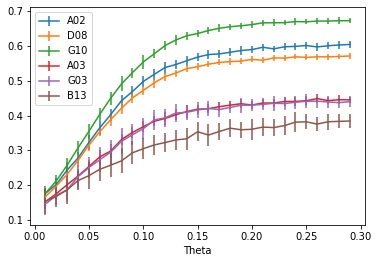

In [36]:
df_list = []
for i in testing_file:
    df_ = theta_df(i,testing_file,all_accs)
    df_list.append(df_)

fig = plt.figure()
ax = fig.gca()
for i in range(len(df_list)):
    df_list[i].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file[i])[0],yerr = 'Std')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\K-fold result\acc_fold{}.jpg'.format(i),dpi =300)

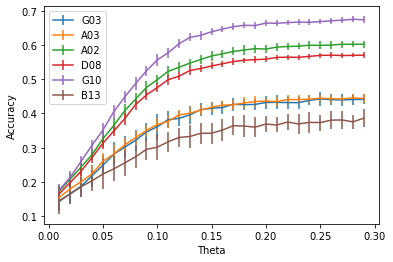

In [89]:
G03 = theta_df('G03.csv',testing_file,all_accs)
A03 = theta_df('A03.csv',testing_file,all_accs)
A02 = theta_df('A02.csv',testing_file,all_accs)
D08 = theta_df('D08.csv',testing_file,all_accs)
G10 = theta_df('G10.csv',testing_file,all_accs)
B13 = theta_df('B13.csv',testing_file,all_accs)

fig = plt.figure()
ax = fig.gca() 
G03.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'G03',yerr = 'Std')
A03.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'A03',yerr = 'Std')
A02.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'A02',yerr = 'Std')
D08.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'D08',yerr = 'Std')
G10.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'G10',yerr = 'Std')
B13.plot(kind = 'line',x = 'Theta',y = 'Accuracy',ax = ax,label = 'B13',yerr = 'Std')
ax.set_ylabel('Accuracy')
os.chdir(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result')
plt.savefig('plot_for_3.jpg',format = 'jpg',dpi = 300)

# K-fold cross validation

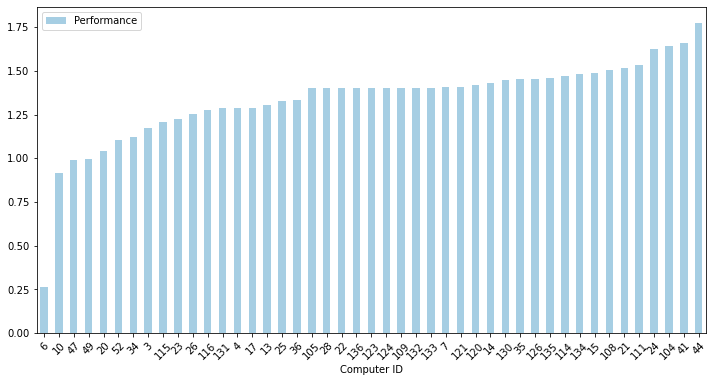

In [44]:
performace = pd.read_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Design_output_uark.csv',index_col=None)
h_perform = performace.sort_values('Co-efficient')
h_perform.plot.bar(x = 'Computer ID',y='Co-efficient',rot = 45,figsize = (12,6),colormap='Paired')
plt.legend(["Performance"])

# High performer group

In [45]:
high_perform_10 = list(h_perform['Computer ID'])[-10:]
high_perform_10

[114, 134, 15, 108, 21, 111, 24, 104, 41, 44]

In [46]:
testing_file_10 = [uark_path + '\\' + str(i) +'.csv' for i in high_perform_10]
train_file_10 = all_file

In [47]:
reward_10 = reward_gen(train_file_10)

### Average Markov Chain Prediction

In [62]:
trans = Train_MC(first_order, training_data= train_file_10, process= process)

In [ ]:
MC_T_10 = []
for file in testing_file_10:
    #    a = pd.read_csv(file)
    ac = calc(trans, file, random_= True)
    MC_T_10.append(ac)
MC_T10 = pd.DataFrame(list(zip(MC_T_10, high_perform_10)), columns = ['MC_T_10', 'Student'])
MC_T10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Compare\MC_avg_T.csv')

### Prediction using Q_Learning

In [24]:
trans = Train_MC(first_order, training_data=train_file_10, process=process)

In [63]:
MC_T_10 = []
for file in testing_file_10:
#    a = pd.read_csv(file)
    ac = calc(trans, file, random_= True)
    MC_T_10.append(ac)
MC_T10 = pd.DataFrame(list(zip(MC_T_10, high_perform_10)), columns = ['MC_T_10', 'Student'])
MC_T10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\MC_avg_T.csv')

In [48]:
Q = Q_table('Analysis',reward=reward_10,alpha=alpha,gamma=gamma)
sequences = sequence_generator(testing_file_10,Q)
all_accs = accuracy_generator(testing_file_10,sequence=sequences)
final_accs_top_10 = []
final_accs_top_std = []
for i in range(len(all_accs)):
    x = np.mean(all_accs[i][28])
    y = np.std(all_accs[i][28])
    final_accs_top_10.append(x)
    final_accs_top_std.append(y)

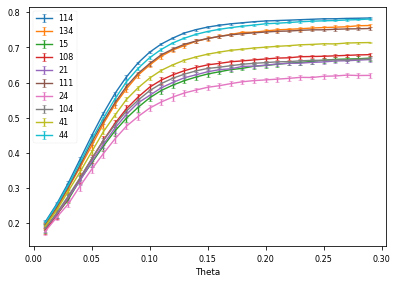

In [55]:
plt.style.use('seaborn-paper')
df_list_10 = []
for k in testing_file_10:
    df_ = theta_df(k,testing_file_10,all_accs)
    df_list_10.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_10)):
    df_list_10[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file_10[j].split('\\')[-1])[0],yerr = 'Std',capsize=2,capthick=0.5)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\top.jpg'.format(i),dpi =300)

<Figure size 576x576 with 0 Axes>

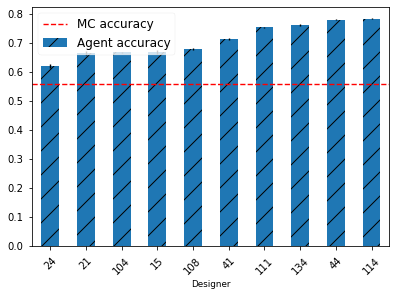

In [78]:
high_df = pd.DataFrame({'Designer':high_perform_10,'Accuracy':final_accs_top_10,'Std':final_accs_top_std})
high_df = high_df.sort_values('Accuracy')
plt.figure(figsize=(8,8))
ax = high_df.plot.bar(x = 'Designer',y = 'Accuracy',yerr = 'Std',rot = 45,hatch = '/')
plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.axhline(y= 0.56, color='r', linestyle='--')
plt.legend(["MC accuracy","Agent accuracy"],fontsize = 12)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\Top_10\accuracy_top.jpg',dpi = 300,bbox_inches = 'tight')

In [81]:
peroform_top_10 = (h_perform['Co-efficient'])[-10:]
df_top_10 = pd.DataFrame(list(zip(high_perform_10,peroform_top_10,final_accs_top_10)),columns=['Student','ANE','Accuracy'])
df_top_10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\Top_10\top10.csv')

[Text(0.5, 0, 'ANE'), Text(1.5, 0, 'Accuracy')]

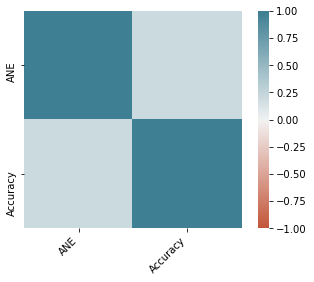

In [32]:
corr = df_top_10.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [34]:
print(corr)

               ANE  Accuracy
ANE       1.000000  0.206244
Accuracy  0.206244  1.000000


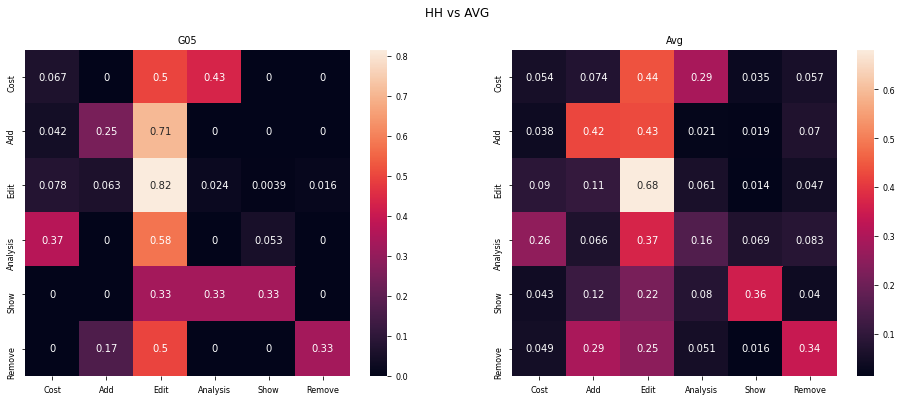

In [160]:
 # Comparision of Highest performer MC vs Average MC
h_mc = reward_gen(['G05.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(h_mc,annot=True,ax=ax[0]).set_title('G05')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('HH vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\h_av.jpg',dpi = 300)

In [89]:
sum(h_avg.iloc[0])

0.9523809523809524

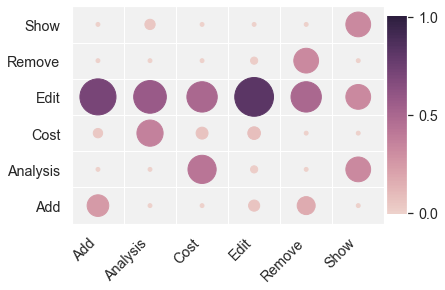

In [177]:
def mat_converter(mat):
    m = pd.melt(mat.reset_index(),id_vars = 'index')
    m.columns = ['x','y','value']
    return m
t = mat_converter(h_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=t['x'],
    y=t['y'],
    size=t['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=t['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\G05.jpg',dpi = 300,bbox_inches = 'tight')

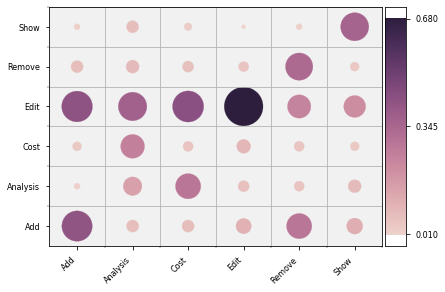

In [169]:
avg = mat_converter(h_avg.round(2))
heatmap(
    x=avg['x'],
    y=avg['y'],
    size=avg['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=avg['value'],
    size_scale = 1500
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\AVG.jpg',dpi = 300)

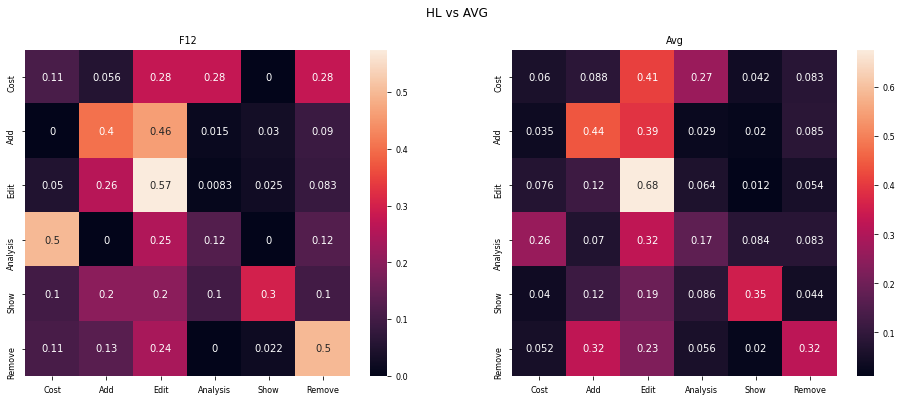

In [74]:
lh_mc = reward_gen(['F12.csv'])

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(lh_mc,annot=True,ax=ax[0]).set_title('F12')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('HL vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\l_av.jpg',dpi = 300)

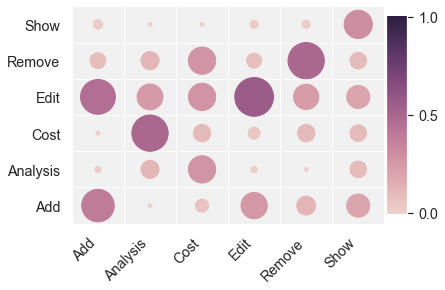

In [175]:
low_h = mat_converter(lh_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=low_h['x'],
    y=low_h['y'],
    size=low_h['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=low_h['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\low.jpg',dpi = 300,bbox_inches = 'tight')

# Low Performer

In [56]:
low_perform_10 = list(h_perform['Computer ID'])[:10]
low_perform_10

[6, 10, 47, 49, 20, 52, 34, 3, 115, 23]

In [57]:
testing_file_10_low = [uark_path + '\\' + str(i) +'.csv' for i in low_perform_10]
train_file_10 = all_file

In [ ]:
reward_10 = reward_gen(train_file_10)

### Average Markov accuracy

In [32]:
trans = Train_MC(first_order,train_file_10, process)

In [64]:
MC_L_10 = []
for file in testing_file_10_low:
    #    a = pd.read_csv(file)
    ac = calc(trans, file, random_= True)
    MC_L_10.append(ac)
MC_L10 = pd.DataFrame(list(zip(MC_L_10, low_perform_10)), columns = ['MC_L_10', 'Student'])
MC_L10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\MC_avg_L.csv')

In [58]:
Q_low = Q_table('Analysis',reward=reward_10,alpha=alpha,gamma=gamma)
sequences = sequence_generator(testing_file_10_low,Q_low)
all_accs = accuracy_generator(testing_file_10_low,sequence=sequences)
final_accs_low_10 = []
final_accs_low_std = []
for i in range(len(all_accs)):
    x = np.mean(all_accs[i][28])
    y = np.std(all_accs[i][28])
    final_accs_low_10.append(x)
    final_accs_low_std.append(y)

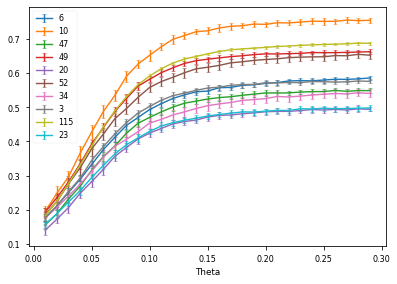

In [59]:
plt.style.use('seaborn-paper')
df_list_10 = []
for k in testing_file_10_low:
    df_ = theta_df(k,testing_file_10_low,all_accs)
    df_list_10.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_10)):
    df_list_10[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(testing_file_10_low[j].split('\\')[-1])[0],yerr = 'Std',capsize=2,capthick=0.5)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\Low_10.jpg'.format(i),dpi =300)

<Figure size 576x576 with 0 Axes>

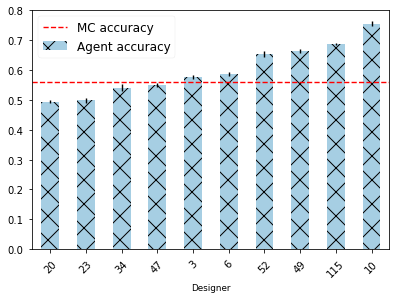

In [82]:
low_df = pd.DataFrame({'Designer':low_perform_10,'Accuracy':final_accs_low_10,'Std':final_accs_low_std})
low_df = low_df.sort_values('Accuracy')
plt.figure(figsize=(8,8))
ax = low_df.plot.bar(x = 'Designer',y = 'Accuracy',yerr = 'Std',rot = 45,colormap='Paired',hatch = 'x')
plt.xticks(fontsize=10)
plt.yticks(fontsize = 10)
plt.axhline(y=0.56, color='r', linestyle='--')
plt.legend(["MC accuracy","Agent accuracy"],fontsize = 12)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\Top_10\accuracy_low.jpg',dpi = 300,bbox_inches = 'tight')

In [83]:
peroform_low_10 = (h_perform['Co-efficient'])[:10]
df_low_10 = pd.DataFrame(list(zip(low_perform_10,peroform_low_10,final_accs_low_10)),columns=['Student','ANE','Accuracy'])
df_low_10.to_csv(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Uark_data\Result\Top_10\low10.csv')

In [181]:
corr = df_low_10.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

NameError: name 'df_low_10' is not defined

In [95]:
print(corr)

               ANE  Accuracy
ANE       1.000000  0.460805
Accuracy  0.460805  1.000000


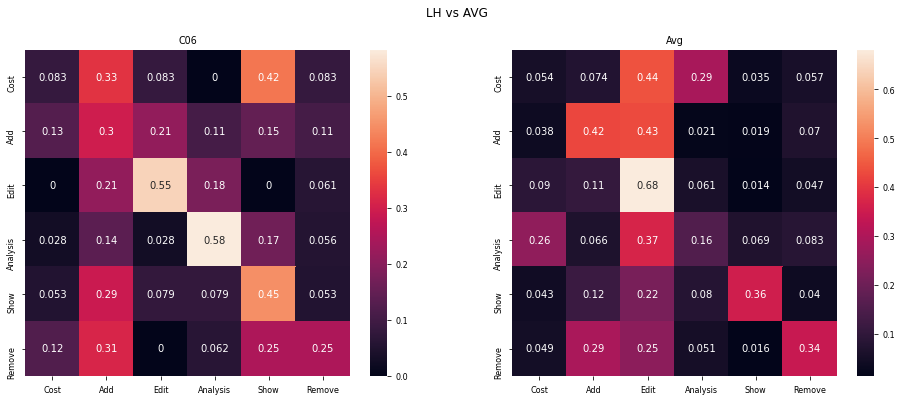

In [151]:
# Comparision of Highest performer MC vs Average MC
l_mc = reward_gen(['C06.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(l_mc,annot=True,ax=ax[0]).set_title('C06')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('LH vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\low one vs top low\l_av.jpg',dpi = 300)

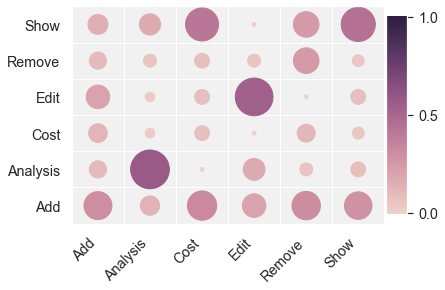

In [186]:
low_h = mat_converter(l_mc.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=low_h['x'],
    y=low_h['y'],
    size=low_h['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=low_h['value'],
    size_scale = 1500,
    color_range  = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\low_low.jpg',dpi = 300,bbox_inches = 'tight')

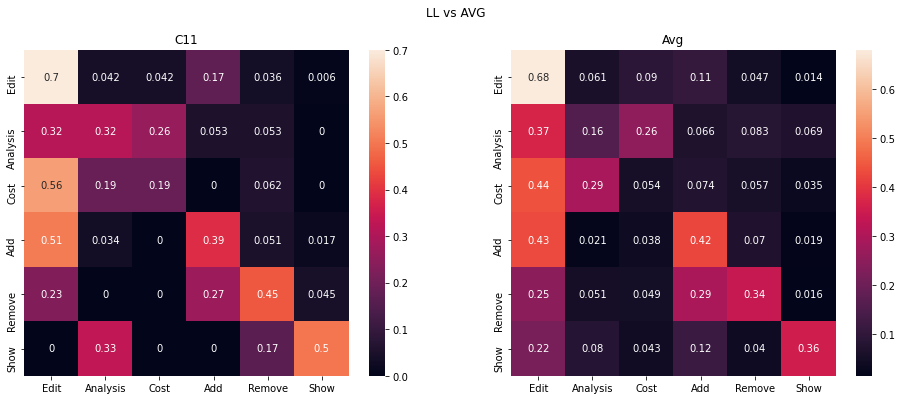

In [99]:
hl_mc = reward_gen(['C11.csv'])

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(hl_mc,annot=True,ax=ax[0]).set_title('C11')
sns.heatmap(h_avg,annot= True,ax = ax[1]).set_title('Avg')
plt.suptitle('LL vs AVG')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\low one vs top low\hl_av.jpg',dpi = 300)

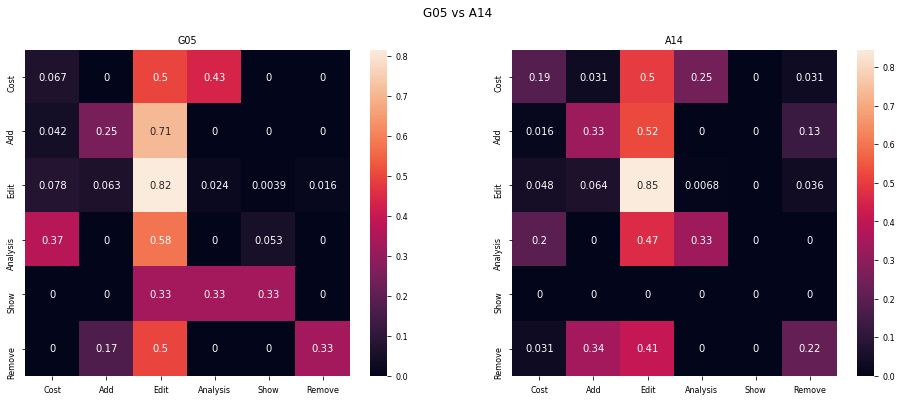

In [155]:
 # Comparision of Highest performer in high group vs highest performer in low group

h_mc = reward_gen(['G05.csv'])
A14 = reward_gen(['A14.csv'])
h_avg = reward_10/42

fig,ax = plt.subplots(1,2,figsize = (16,6))
sns.heatmap(h_mc,annot=True,ax=ax[0]).set_title('G05')
sns.heatmap(A14,annot= True,ax = ax[1]).set_title('A14')
plt.suptitle('G05 vs A14')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\G05_A14.jpg',dpi = 300)

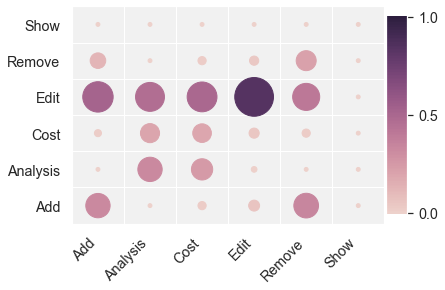

In [187]:
A14_ = mat_converter(A14.round(2))
plt.figure(figsize=(6, 4))
sns.set(font_scale = 1.3)
heatmap(
    x=A14_['x'],
    y=A14_['y'],
    size=A14_['value'].abs(),
    marker = 'o',
    palette=sns.cubehelix_palette(128)[::1],
    color=A14_['value'],
    size_scale = 1500,
    color_range = (0,1)
)
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\top one vs top last\A14.jpg',dpi = 300,bbox_inches = 'tight')

# Train on high performance designer

In [134]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
alpha = 0.1
gamma = 0.9
start_theta = 0.1
end_theta = 2

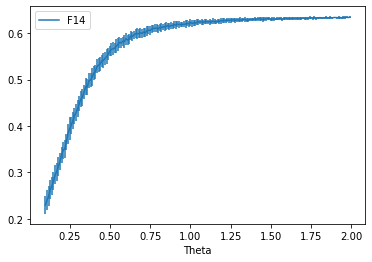

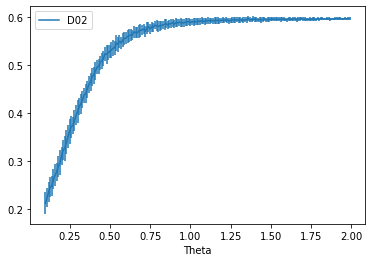

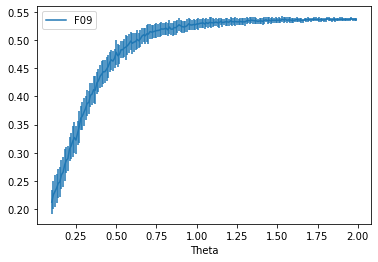

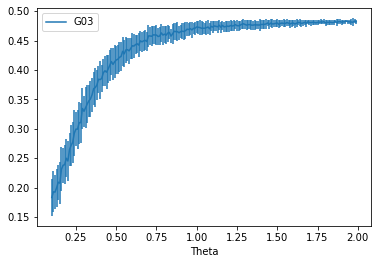

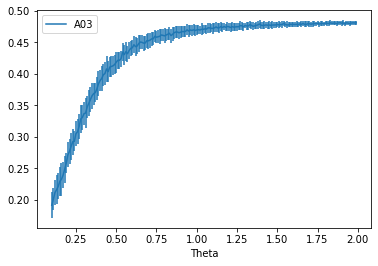

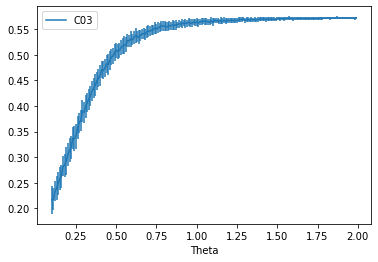

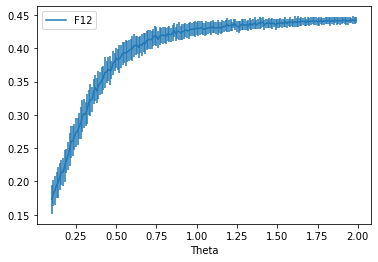

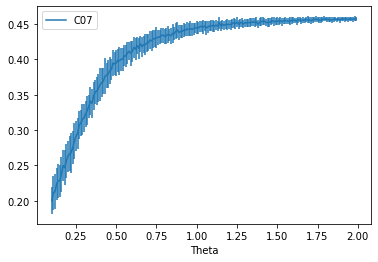

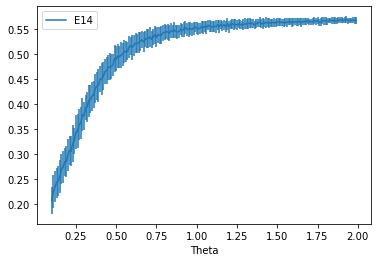

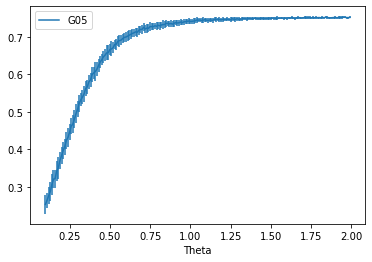

In [135]:
for train_index,test_index in loo.split(testing_file_10):
    train = [testing_file_10[x] for x in train_index]
    test =  [testing_file_10[x] for x in test_index]
    Q = Q_table('Analysis',reward=reward_gen(train),alpha=alpha,gamma=gamma)
    sequences = sequence_generator(test,Q,start_theta=start_theta,end_theta=end_theta)
    all_accs = accuracy_generator(test,sequence=sequences)
    df_list = []
    for k in test:
        df_ = theta_df(k,test,all_accs,start_theta=start_theta,end_theta=end_theta)
        df_list.append(df_)

    fig = plt.figure()
    ax = fig.gca()
    for j in range(len(df_list)):
        df_list[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(test[j])[0],yerr = 'Std')
    plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\Top_10\Only_top\test_{}.jpg'.format(test_index[0]),dpi =300)       

# Testing next action based on predicted action

In [162]:
def sequence_generator_predicted(file,Q,start_theta=0.01,end_theta=0.3,iteration = 50):
    sequences = []
    for l in range(len(file)):
        seq = pd.read_csv(file[l])['0'] 
        seq = [sub.replace('Add','Formulation') for sub in seq]
        total_route = []
        for j in np.arange(start_theta,end_theta,0.01):
            route_50 = []
            for k in range(iteration):
                start_action = seq[0]
                route = [start_action]
            #    next_action = start_action
                for i in range(len(seq)-1):
                    starting_state = location_to_states[start_action]
                    next_state = random.choices(np.arange(0,6),(prob(j,Q[starting_state,])))[0]
                    next_action = state_to_location[next_state]
                    route.append(next_action)
                    route = [sub.replace('Formulation','Add') for sub in route]
                    start_action = next_action
                route_50.append(route)
            total_route.append(route_50)
        sequences.append(total_route)
    return sequences

In [161]:
G05 = ['G05.csv']
other = [x for x in all_file if x not in testing_file_10_low]
rwrd_toal = reward_gen(other)
rwrd_toal

,Cost,Add,Edit,Analysis,Show,Remove
Cost,2.257088,3.128367,18.463265,12.292608,1.456469,2.402202
Add,1.594395,17.814222,18.009188,0.863770,0.777992,2.940434
Edit,3.775691,4.486128,28.622702,2.542122,0.589675,1.983683
Analysis,10.720313,2.787425,15.540781,6.570547,2.898771,3.482163
Show,1.819936,4.911071,9.208477,3.360045,15.027716,1.672756
Remove,2.066795,12.316035,10.455032,2.129087,0.653745,14.379307


In [163]:
Q_total = Q_table('Analysis',reward=rwrd_toal,alpha=alpha,gamma=gamma)
sequences = sequence_generator_predicted(G05,Q_total)
all_accs = accuracy_generator(G05,sequence=sequences)

In [164]:
Q_total

array([[11.47612903, 12.21118529, 30.73013756, 20.63490429,  7.89907409,
         9.21877287],
       [10.81343583, 26.8970396 , 30.27606013,  9.20606618,  7.22059673,
         9.75700457],
       [12.99473191, 13.56894578, 40.88957405, 10.88441814,  7.03227961,
         8.80025361],
       [19.93935449, 11.87024264, 27.8076532 , 14.91284323,  9.34137542,
        10.29873415],
       [11.03897683, 13.99388893, 21.47534955, 11.7023407 , 21.47032045,
         8.48932671],
       [11.28583603, 21.39885279, 22.7219038 , 10.47138246,  7.09635029,
        21.19587777]])

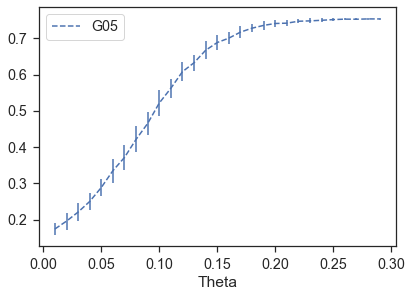

In [201]:
sns.set_style("ticks")
df_list_G05 = []
for k in G05:
    df_ = theta_df(k,G05,all_accs)
    df_list_G05.append(df_)

fig = plt.figure()
ax = fig.gca()
for j in range(len(df_list_G05)):
    df_list_G05[j].plot(kind = 'line', x = 'Theta', y = 'Accuracy',ax = ax, label = os.path.splitext(G05[j])[0],yerr = 'Std',linestyle = '--')
plt.savefig(r'C:\Users\mhrahman\OneDrive - University of Arkansas\RL_\Result\G05\G05.jpg'.format(i),dpi =300)